# Image to Image

In [ ]:
import base64
import io
import json
import os
import sys
import boto3
from PIL import Image

module_path = ".."
sys.path.append(os.path.abspath(module_path))
from utils import bedrock, print_ww

bedrock_runtime = boto3.client(
    service_name='bedrock-runtime', 
    aws_access_key_id=os.getenv('aws_access_key_id'),
    aws_secret_access_key=os.getenv('aws_secret_access_key'),
    region_name='us-west-2'
)

In [ ]:
negative_prompts = [
    "poorly rendered",
    "poor background details",
    "deformed city"
    "poorly drawn futuristic city",
    "disfigured city features",
]
style_preset = "cinematic"
clip_guidance_preset = "FAST_BLUE"
sampler = "K_DPMPP_2S_ANCESTRAL"

In [5]:
def convert_image_to_b64(image_input) -> str:
    if isinstance(image_input, str):
        return handle_file_input(image_input)
    elif isinstance(image_input, Image.Image):
        return handle_pil_input(image_input)
    else:
        raise TypeError(f"Unsupported type: {type(image_input)}")

def handle_file_input(file_path: str) -> str:
    if os.path.exists(file_path):
        print(f"Loading image from: {file_path}")
        with open(file_path, "rb") as file:
            return encode_to_b64(file.read())
    else:
        raise FileNotFoundError(f"No file found at: {file_path}")

def handle_pil_input(pil_image: Image.Image) -> str:
    print("Transforming PIL Image to base64")
    byte_buffer = io.BytesIO()
    pil_image.save(byte_buffer, format="PNG")
    return encode_to_b64(byte_buffer.getvalue())

def encode_to_b64(byte_data: bytes) -> str:
    return base64.b64encode(byte_data).decode("utf-8")

image_1 = Image.open('data/image_1.png')
encoded_image_b64 = convert_image_to_b64(image_1)
print(encoded_image_b64[:80] + "...")

Transforming PIL Image to base64
iVBORw0KGgoAAAANSUhEUgAAAwAAAAIACAIAAAC6lJxtAAEAAElEQVR4nKz9WWIkSY4sAApg5u6MyMpa...


In [6]:
new_change_prompt = "add more futuristic elements such as futuristic vehicles"

In [8]:
def construct_request_payload(
        alteration_prompt, 
        negative_prompts_list, 
        initial_image_b64, 
        preset_style, 
        preset_clip_guidance, 
        sampler_type
    ):
    text_prompts = [{"text": alteration_prompt, "weight": 1.0}]
    text_prompts.extend([{"text": np, "weight": -1.0} for np in negative_prompts_list])
    
    payload = {
        "text_prompts": text_prompts,
        "cfg_scale": 10,
        "init_image": initial_image_b64,
        "seed": 321,
        "start_schedule": 0.6,
        "steps": 50,
        "style_preset": preset_style,
        "clip_guidance_preset": preset_clip_guidance,
        "sampler": sampler_type,
    }
    
    return json.dumps(payload)

def invoke_model(runtime, payload, model_identifier):
    response = runtime.invoke_model(body=payload, modelId=model_identifier)
    return json.loads(response.get("body").read())

request_payload = construct_request_payload(
    new_change_prompt, negative_prompts, encoded_image_b64, style_preset, clip_guidance_preset, sampler
)

model_identifier = "stability.stable-diffusion-xl"
bedrock_response = invoke_model(bedrock_runtime, request_payload, model_identifier)

print(bedrock_response["result"])
b64_str_image_2 = bedrock_response["artifacts"][0].get("base64")
print(f"{b64_str_image_2[0:80]}...")


success
iVBORw0KGgoAAAANSUhEUgAAAwAAAAIACAIAAAC6lJxtAAD06mVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


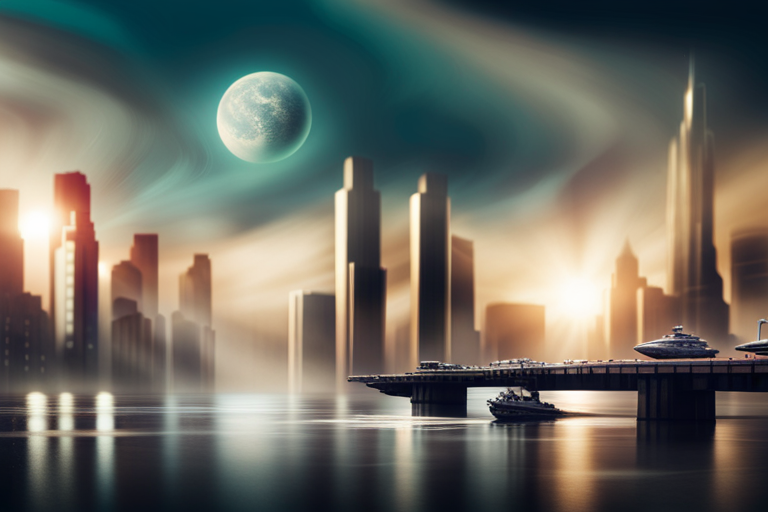

In [9]:
image_2 = Image.open(io.BytesIO(base64.decodebytes(bytes(b64_str_image_2, "utf-8"))))
image_2.save("data/image_2.png")
image_2

# Image Inpainting

In [ ]:
os.makedirs("output", exist_ok=True) #A
mask_img = Image.open('output/mask_img.png') #B
mask_img.show() #C

In [ ]:
inpaint_text = "integrate sky elements"

In [ ]:
def image_to_base64(img):
    buffered = io.BytesIO()
    img.save(buffered, format="PNG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8") #A

inpaint_request = json.dumps({
    "text_prompts": [{"text": inpaint_text}],
    "init_image": image_to_base64(image_2), #B
    "mask_source": "MASK_IMAGE_BLACK",
    "mask_image": image_to_base64(mask_img), #C
    "cfg_scale": 10,
    "seed": 123,
    "style_preset": style_preset,
})
model_identifier = "stability.stable-diffusion-xl"

In [ ]:
response = boto3_bedrock.invoke_model(body=inpaint_request, modelId=model_identifier) #A
response_content = json.loads(response.get("body").read()) #B

image_3_b64 = response_content["artifacts"][0].get("base64") #C
print(f"{image_3_b64[:80]}...")

In [ ]:
inpaint_image = Image.open(io.BytesIO(base64.b64decode(bytes(image_3_b64, "utf-8"))))
inpaint_image.save("output/inpainted_image.png")
inpaint_image.show()